In [2]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets
from sklearn.linear_model import LogisticRegression

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [3]:
dataset_orig = pd.read_csv('../../../data/adult.data.csv')

## Drop categorical features
dataset_orig = dataset_orig.drop(['fnlwgt','education'],axis=1)

## Drop NULL values
dataset_orig = dataset_orig.dropna()

## Change symbolics to numerics
dataset_orig['sex'] = np.where(dataset_orig['sex'] == ' Male', 1, 0)
dataset_orig['race'] = np.where(dataset_orig['race'] != ' White', 0, 1)
dataset_orig['Probability'] = np.where(dataset_orig['Probability'] == ' <=50K', 0, 1)

non_numeric_columns = list(dataset_orig.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    dataset_orig[col] = le.fit_transform(dataset_orig[col])

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset_orig = pd.DataFrame(scaler.fit_transform(dataset_orig),columns = dataset_orig.columns)

dataset_orig_train, dataset_orig_test = train_test_split(dataset_orig, test_size=0.2, shuffle = True)

(dataset_orig.head(5))

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Probability
0,0.301370,0.875,0.800000,0.666667,0.071429,0.2,1.0,1.0,0.02174,0.0,0.397959,0.951220,0.0
1,0.452055,0.750,0.800000,0.333333,0.285714,0.0,1.0,1.0,0.00000,0.0,0.122449,0.951220,0.0
2,0.287671,0.500,0.533333,0.000000,0.428571,0.2,1.0,1.0,0.00000,0.0,0.397959,0.951220,0.0
3,0.493151,0.500,0.400000,0.333333,0.428571,0.0,0.0,1.0,0.00000,0.0,0.397959,0.951220,0.0
4,0.150685,0.500,0.800000,0.333333,0.714286,1.0,0.0,0.0,0.00000,0.0,0.397959,0.121951,0.0


# Fairway

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy
protected_attribute = 'sex'

dataset_orig_train,dataset_orig_test = train_test_split(dataset_orig,test_size=0.2,random_state=0)
X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))
print("=="*10)
dataset_orig_male , dataset_orig_female = [x for _, x in dataset_orig_train.groupby(dataset_orig_train[protected_attribute] == 0)]
dataset_orig_male[protected_attribute] = 0
X_train_male, y_train_male = dataset_orig_male.loc[:, dataset_orig_male.columns != 'Probability'], dataset_orig_male['Probability']
clf_male = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
clf_male.fit(X_train_male, y_train_male)
X_train_female, y_train_female = dataset_orig_female.loc[:, dataset_orig_female.columns != 'Probability'], dataset_orig_female['Probability']
clf_female = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
clf_female.fit(X_train_female, y_train_female)

for index,row in dataset_orig_train.iterrows():
    row_ = [row.values[0:len(row.values)-1]]
    y_male = clf_male.predict(row_)
    y_female = clf_female.predict(row_)
    if y_male[0] != y_female[0]:        
        dataset_orig_train = dataset_orig_train.drop(index)

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

aod :race 0.03
eod :race 0.12
SPD: 0.1
DI: 0.61
aod :race 0.03
eod :race 0.12
SPD: 0.09
DI: 0.61


# Graph

In [14]:
causal_graph = """
digraph {
marital_status;
workclass;
occupation;
race;
sex;
Probability;
U[label="Unobserved Confounders"];

sex -> Probability;
race -> Probability;
sex -> marital_status; marital_status -> Probability; 
workclass -> occupation;
marital_status -> occupation; occupation -> Probability;
marital_status -> relationship; relationship -> Probability
race -> occupation; race -> Probability;
race -> education_num; education_num -> workclass;
workclass -> Probability;
U->sex;U->race;U->Probability;
}
"""

## dowhy works for binary inputs only


dataset_orig_train['Probability'] = np.where(dataset_orig_train['Probability'] == 0, False, True)
dataset_orig_train[protected_attribute] = np.where(dataset_orig_train[protected_attribute] == 1, True, False)

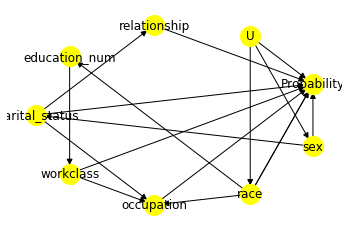

In [15]:
# With graph
model=CausalModel(
        data = dataset_orig_train,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [16]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                             
───────(Expectation(Probability|marital_status,sex,relationship))
d[race]                                                          
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,marital_status,sex,relationship,U) = P(Probability|race,marital_status,sex,relationship)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [17]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                             
───────(Expectation(Probability|marital_status,sex,relationship))
d[race]                                                          
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,marital_status,sex,relationship,U) = P(Probability|race,marital_status,sex,relationship)

## Realized estimand
b: Probability~race+marital_status+sex+relationship
Target units: ate

## Estimate
Mean value: 0.037883888697931946

Causal Estimate is 0.037883888697931946


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [28]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.10746751663338705
New effect:0.1094877657234566



# Replace Treatment with Placebo

In [38]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.03990321007602089
New effect:0.0006089524974127414
p value:0.45



# Remove Random Subset of Data

In [18]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.037883888697931946
New effect:0.03856768017842192
p value:0.39

